# Manual MLP Implementation for MNIST Classification (with Backpropagation)

This notebook presents a manual implementation of a Multi-Layer Perceptron (MLP) to classify handwritten digits from the MNIST dataset. It includes a from-scratch implementation of backpropagation and trains a simple neural network with a single hidden layer.

## 1. Loading the MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [2]:
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

## 2. Data Preprocessing

In [4]:
X = ((X / 255.) - .5) * 2

## 3. Visualizing Sample Images

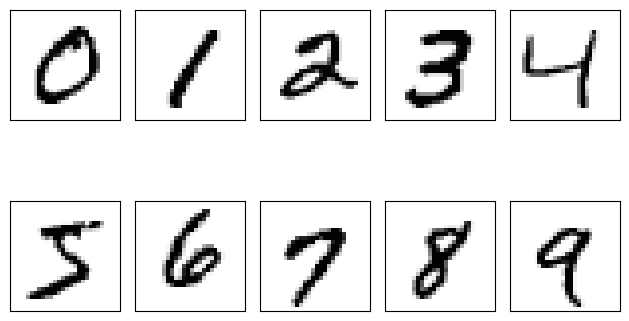

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

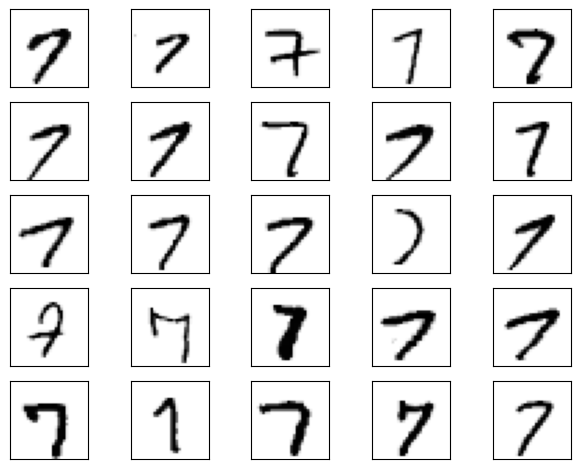

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

## 4. Splitting the Dataset

In [7]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=1, stratify=y_temp)

## 5. Defining the Neural Network Architecture

In [8]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i,val in enumerate(y):
        ary[i,val] = 1
    return ary

class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        # hidden layer
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
        
    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        d_z_out__a_h = self.weight_out
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h)

        d_z_h__d_w_h = x
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h

In [9]:
model = NeuralNetMLP(num_features=28*28,
                    num_hidden=50,
                    num_classes=10)

## 6. Training the Model

In [10]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [11]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [12]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    return mse, acc

In [13]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc * 100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.1%


In [14]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            a_h, a_out = model.forward(X_train_mini)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(
                X_train_mini, a_h, a_out, y_train_mini
            )
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [15]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.92% | Valid Acc: 75.88%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.77% | Valid Acc: 84.50%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.32% | Valid Acc: 87.26%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.43% | Valid Acc: 88.30%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.16% | Valid Acc: 89.02%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.72% | Valid Acc: 89.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.14% | Valid Acc: 89.78%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.46% | Valid Acc: 90.28%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.80% | Valid Acc: 90.36%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 90.56%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.14% | Valid Acc: 90.60%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.49% | Valid Acc: 90.96%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.66% | Valid Acc: 91.38%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.84

## 7. Plotting Training Loss and Accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

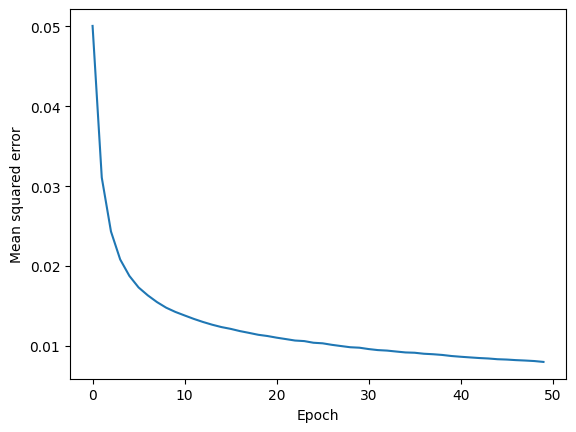

In [16]:
plt.plot(range(len(epoch_loss)),epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show

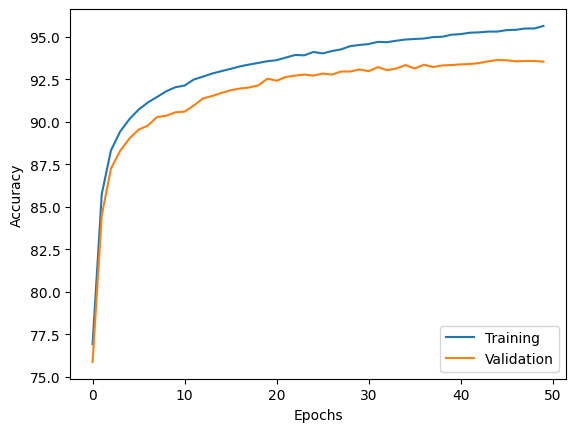

In [17]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

## 8. Evaluating the Model on Test Data

In [18]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Test accuracy: 94.91%


## 9. Visualizing Sample Predictions on Test Data

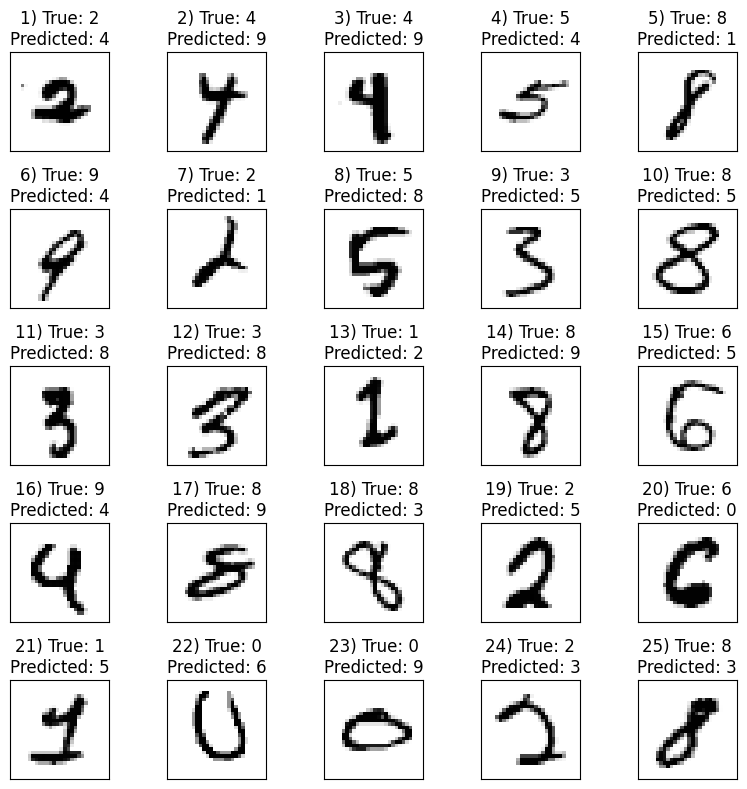

In [19]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) True: {correct_labels[i]}\nPredicted: {misclassified_labels[i]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()